# Models de classificació de documents en múltiples categories

### Importació de biblioteques/dependències necessàries

In [205]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import pickle
from googletrans import Translator
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.svm import SVC
from nltk.stem import SnowballStemmer
import nltk
import unidecode
import re
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

## Càrrega de la base de dades

#### Càrrega de tot el dataset, eliminació stopwords, aplicació stemmer, eliminació signes d'accentuació i puntuació, eliminació dígits i transformació del text a minúscula

In [206]:
stemmer = SnowballStemmer('spanish')

In [207]:
#Per a cada categoria del dataset es realitza el mateix pre-processament
pwd_list_automobil = (glob.glob("../00Data/dataset_pdf/Automobil/*.pdf")) #Llistar path arxius categoria
listado_titulos_automobil_removed_stopwords = []
listado_titulos_automobil_stemmed = []
titulos_automobil_preprocesados = []

for element in pwd_list_automobil:
    texto = element.split('/')[-1].split('.pdf')[0]
    texto = texto.replace('_',' ')
    #Tokenitzo
    word_tokens = nltk.word_tokenize(texto) 
    #Filtro NO stopwords
    filtered_sentence = [w for w in word_tokens if not w in stopwords.words('spanish')] 
    listado_titulos_automobil_removed_stopwords.append(" ".join(filtered_sentence)) 
    
for titulo in listado_titulos_automobil_removed_stopwords:
    #Aplico stemmer sobre les paraules filtrades
    listado_titulos_automobil_stemmed.append(" ".join([stemmer.stem(word) for word in nltk.word_tokenize(titulo)]))

for titulo in listado_titulos_automobil_stemmed:
    #Eliminació signes de puntuació, accentuació
    titulos_automobil_preprocesados.append(re.sub(r'[^\w\s]','',titulo))
    
    
pwd_list_biomedicina = (glob.glob("../00Data/dataset_pdf/Biomedicina/*.pdf"))
listado_titulos_biomedicina_removed_stopwords = []
listado_titulos_biomedicina_stemmed = []
titulos_biomedicina_preprocesados = []

for element in pwd_list_biomedicina:
    texto = element.split('/')[-1].split('.pdf')[0]
    texto = texto.replace('_',' ')
    word_tokens = nltk.word_tokenize(texto) 
    filtered_sentence = [w for w in word_tokens if not w in stopwords.words('spanish')]
    listado_titulos_biomedicina_removed_stopwords.append(" ".join(filtered_sentence))
    
for titulo in listado_titulos_biomedicina_removed_stopwords:
    listado_titulos_biomedicina_stemmed.append(" ".join([stemmer.stem(word) for word in nltk.word_tokenize(titulo)]))

for titulo in listado_titulos_biomedicina_stemmed:
    titulos_biomedicina_preprocesados.append(re.sub(r'[^\w\s]','',titulo))
    
    
pwd_list_electronica = (glob.glob("../00Data/dataset_pdf/Electronica/*.pdf"))
listado_titulos_electronica_removed_stopwords = []
listado_titulos_electronica_stemmed = []
titulos_electronica_preprocesados = []

for element in pwd_list_electronica:
    texto = element.split('/')[-1].split('.pdf')[0]
    texto = texto.replace('_',' ')
    word_tokens = nltk.word_tokenize(texto) 
    filtered_sentence = [w for w in word_tokens if not w in stopwords.words('spanish')]
    listado_titulos_electronica_removed_stopwords.append(" ".join(filtered_sentence))
    
for titulo in listado_titulos_electronica_removed_stopwords:
    listado_titulos_electronica_stemmed.append(" ".join([stemmer.stem(word) for word in nltk.word_tokenize(titulo)]))

for titulo in listado_titulos_electronica_stemmed:
    titulos_electronica_preprocesados.append(re.sub(r'[^\w\s]','',titulo))
    
    
    
pwd_list_fluids = (glob.glob("../00Data/dataset_pdf/Mecanica_fluids/*.pdf"))
listado_titulos_fluids_removed_stopwords = []
listado_titulos_fluids_stemmed = []
titulos_fluids_preprocesados = []

for element in pwd_list_fluids:
    texto = element.split('/')[-1].split('.pdf')[0]
    texto = texto.replace('_',' ')
    word_tokens = nltk.word_tokenize(texto) 
    filtered_sentence = [w for w in word_tokens if not w in stopwords.words('spanish')]
    listado_titulos_fluids_removed_stopwords.append(" ".join(filtered_sentence))
    
for titulo in listado_titulos_fluids_removed_stopwords:
    listado_titulos_fluids_stemmed.append(" ".join([stemmer.stem(word) for word in nltk.word_tokenize(titulo)]))

for titulo in listado_titulos_fluids_stemmed:
    titulos_fluids_preprocesados.append(re.sub(r'[^\w\s]','',titulo))
    

In [208]:
df1 = pd.DataFrame({'Label':'Automobil','Doc_name': titulos_automobil_preprocesados})
df2 = pd.DataFrame({'Label':'Biomedicina','Doc_name': titulos_biomedicina_preprocesados})
df3 = pd.DataFrame({'Label':'Electronica','Doc_name': titulos_electronica_preprocesados})
df4 = pd.DataFrame({'Label':'Mecanica_fluids','Doc_name': titulos_fluids_preprocesados})

df = pd.concat([df1,df2,df3,df4]) 
df.head(10)

,Label,Doc_name
0,Automobil,disen vehicul desplaz personal ciud
1,Automobil,disen bascul traser motociclet
2,Automobil,mecanism elev per gru dautomobils carreg lateral
3,Automobil,disen caj cambi seis veloc
4,Automobil,analisis disen implementacion septim relacion ...
5,Automobil,laboratori ensay certificacion vehicul
6,Automobil,disen transmision todoterren adapt vehicul tip...
7,Automobil,cap activ
8,Automobil,disen element suspension vehicul competicion
9,Automobil,disen implementacion vehicul uniaxial control ...


In [209]:
df.Label.unique()

array(['Automobil', 'Biomedicina', 'Electronica', 'Mecanica_fluids'],
      dtype=object)

In [210]:
#Quantitat de documents
len(df)

79

In [211]:
#Comprovació dels títols 
len(df.Doc_name) == len(df.Doc_name.unique())

True

#### Train test split

In [212]:
#Defineixo les variables i les etiquetes. X: variables, y: etiquetes
X = df.Doc_name
y = df.Label
print(X.shape)
print(y.shape)

(79,)
(79,)


In [213]:
#Separació del dataset en train i test. 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(59,)
(20,)
(59,)
(20,)


## FEATURING

### Countvectorizer (Term frequency)  --> COUNT BASED FEATURE EXTRACTION

In [214]:
vect = CountVectorizer(stop_words=stopwords.words('spanish')) 
#S'inicialitza el vectoritzador i s'eliminen les stopwords del castellà
#Es pot configurar min_df o max_df com a híper-paràmetre
#You must always have a 1D object so CountVectorizer can turn into a 2D object for the model to be built on

In [215]:
#Entreno el vectoritzador, l'ajusto amb les dades de X_train i transformo les mateixes
X_train_dtm = vect.fit_transform(X_train)

In [216]:
# Transformo els títols de X_test a partir del vectoritzador prèviament entrenat amb X_train
X_test_dtm = vect.transform(X_test) 

In [217]:
### Transformració de totes les dades disponibles (X_train+X_test)
vect_max = CountVectorizer(stop_words=stopwords.words('spanish'))
X_transf_dtm = vect_max.fit_transform(X)

### PCA 2D de tot el conjunt

In [218]:
input_PCA_full_cv1 = X_transf_dtm.toarray()
#Fixo el número de components principals // Dimensions
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(input_PCA_full_cv1)
#DataFrame amb els dos components principals i els seus labels corresponents
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['labels'] = list(y)

In [219]:
principalDf.head(5)

,principal component 1,principal component 2,labels
0,0.928449,0.239416,Automobil
1,0.706155,0.173175,Automobil
2,-0.168962,-0.204358,Automobil
3,0.707506,0.173719,Automobil
4,1.133711,0.247745,Automobil


In [220]:
explained_variance = pca.explained_variance_ratio_
print('El component principal 1 conté un ratio de variança = '+str(explained_variance[0])+' mentre que el component principal 2 conté un ratio de variança de '+str(explained_variance[1]))

El component principal 1 conté un ratio de variança = 0.05005665326979357 mentre que el component principal 2 conté un ratio de variança de 0.04020930292003918


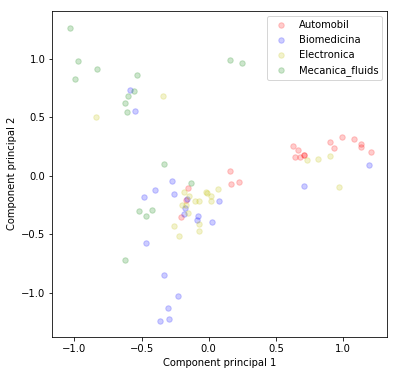

In [221]:
##Plotting 2D

fig2 = plt.figure(figsize = (6,6))
ax3 = fig2.add_subplot(1,1,1) 
ax3.set_xlabel('Component principal 1', fontsize = 10)
ax3.set_ylabel('Component principal 2', fontsize = 10)
#ax3.set_title('PCA 2D - Totes les dades - Featuring CV Countbased', fontsize = 20)

targets = y.unique()
colors = ['r', 'b','y','g','k']

for target, color in zip(targets,colors):
    indicesToKeep = principalDf['labels'] == target
    ax3.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 30,alpha = 0.2)

ax3.legend(targets)



### PCA 2D del conjunto de train

In [222]:
input_PCA_full_cv1 = X_train_dtm.toarray()
pca2 = PCA(n_components=2)
principalComponents = pca2.fit_transform(input_PCA_full_cv1)
principalDf2 = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf2['labels'] = list(y_train)

In [223]:
principalDf2.head(5)

,principal component 1,principal component 2,labels
0,1.233183,0.292151,Automobil
1,-0.509077,-0.611040,Mecanica_fluids
2,0.957690,-0.126779,Electronica
3,1.373269,0.247815,Biomedicina
4,-0.715717,1.437459,Biomedicina


In [224]:
explained_variance = pca2.explained_variance_ratio_
print('El component principal 1 conté un ratio de variança = '+str(explained_variance[0])+' mentre que la componente principal 2 conté un ratio de variança de '+str(explained_variance[1]))

El component principal 1 conté un ratio de variança = 0.05824032505179005 mentre que la componente principal 2 conté un ratio de variança de 0.047930506576639165


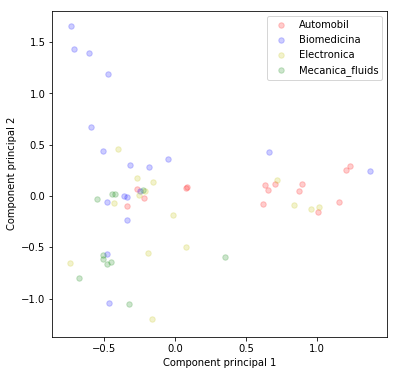

In [225]:
##Plotting 2D

fig2 = plt.figure(figsize = (6,6))
ax3 = fig2.add_subplot(1,1,1) 
ax3.set_xlabel('Component principal 1', fontsize = 10)
ax3.set_ylabel('Component principal 2', fontsize = 10)
#ax3.set_title('PCA 2D - Conjunt train - CV countbased', fontsize = 20)

targets = y.unique()
colors = ['r', 'b','y','g','k']

for target, color in zip(targets,colors):
    indicesToKeep = principalDf2['labels'] == target
    ax3.scatter(principalDf2.loc[indicesToKeep, 'principal component 1']
               , principalDf2.loc[indicesToKeep, 'principal component 2'], c = color, s = 30,alpha = 0.2)

ax3.legend(targets)



### Countvectorizer (Binary Weighting) --> Binary feature representation

In [226]:
cv = CountVectorizer(binary=True,max_df =0.90, stop_words=stopwords.words('spanish'))
#max_df permet ignorar les paraules que apareixen en el 90% dels documents
#S'eliminen les stopwords en castellà 

In [227]:
X_train_dtm2 = cv.fit_transform(X_train)

In [228]:
X_test_dtm2 = cv.transform(X_test)

In [229]:
### Transformació de TOTES LES DADES DISPONIBLES
cv_max = CountVectorizer(binary=True,max_df =0.90, stop_words=stopwords.words('spanish')) 
X_transf_dtm2 = cv_max.fit_transform(X) #Faig un fit transform del countVectorizer amb tots els títols pre-processats

### PCA 2D de tot el conjunt (cv binary weighting)

In [230]:
input_PCA_full_cv1 = X_transf_dtm2.toarray()
pca3 = PCA(n_components=2)
principalComponents = pca3.fit_transform(input_PCA_full_cv1)
principalDf3 = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf3['labels'] = list(y)
principalDf3.head(5)

,principal component 1,principal component 2,labels
0,0.926774,0.249339,Automobil
1,0.705009,0.182453,Automobil
2,-0.169129,-0.216630,Automobil
3,0.706359,0.183039,Automobil
4,1.132295,0.259597,Automobil


In [231]:
explained_variance = pca3.explained_variance_ratio_
print('El componente principal 1 conté un ratio de variança = '+str(explained_variance[0])+' mentre que el component principal 2 conté un ratio de variança de '+str(explained_variance[1]))

El componente principal 1 conté un ratio de variança = 0.050636574582241925 mentre que el component principal 2 conté un ratio de variança de 0.040293206720242836


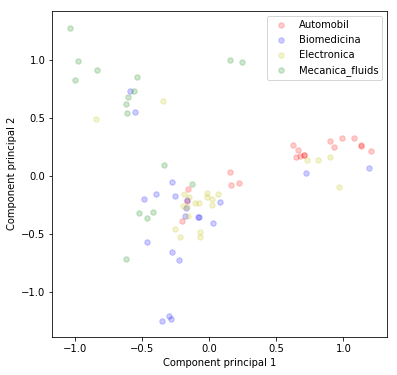

In [232]:
##Plotting 2D

fig2 = plt.figure(figsize = (6,6))
ax3 = fig2.add_subplot(1,1,1) 
ax3.set_xlabel('Component principal 1', fontsize = 10)
ax3.set_ylabel('Component principal 2', fontsize = 10)
#ax3.set_title('PCA 2D - Totes les dades - CV binary', fontsize = 20)

targets = y.unique()
colors = ['r', 'b','y','g','k']

for target, color in zip(targets,colors):
    indicesToKeep = principalDf3['labels'] == target
    ax3.scatter(principalDf3.loc[indicesToKeep, 'principal component 1']
               , principalDf3.loc[indicesToKeep, 'principal component 2'], c = color, s = 30,alpha = 0.2)

ax3.legend(targets)



### PCA 2D conjunt de train (cv binary weighting)

In [233]:
input_PCA_full_cv1 = X_train_dtm2.toarray()
pca4 = PCA(n_components=2)
principalComponents = pca4.fit_transform(input_PCA_full_cv1)
principalDf4 = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf4['labels'] = list(y_train)
principalDf4.head(5)

,principal component 1,principal component 2,labels
0,1.233479,0.300205,Automobil
1,-0.524410,-0.590876,Mecanica_fluids
2,0.953977,-0.150646,Electronica
3,1.370408,0.293662,Biomedicina
4,-0.695439,1.491004,Biomedicina


In [234]:
explained_variance = pca4.explained_variance_ratio_
print('El componente principal 1 conté un ratio de variança = '+str(explained_variance[0])+' mentre que el component principal 2 conté un ratio de variança de '+str(explained_variance[1]))

El componente principal 1 conté un ratio de variança = 0.059086041372236296 mentre que el component principal 2 conté un ratio de variança de 0.04808443527803817


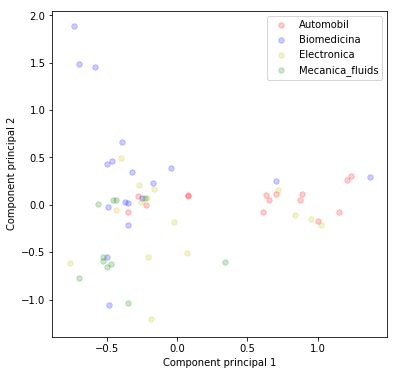

In [235]:
##Plotting 2D

fig2 = plt.figure(figsize = (6,6))
ax3 = fig2.add_subplot(1,1,1) 
ax3.set_xlabel('Component principal 1', fontsize = 10)
ax3.set_ylabel('Component principal 2', fontsize = 10)
#ax3.set_title('PCA 2D - Conjunt Train - CV binary', fontsize = 20)

targets = y.unique()
colors = ['r', 'b','y','g','k']

for target, color in zip(targets,colors):
    indicesToKeep = principalDf4['labels'] == target
    ax3.scatter(principalDf4.loc[indicesToKeep, 'principal component 1']
               , principalDf4.loc[indicesToKeep, 'principal component 2'], c = color, s = 30,alpha = 0.2)

ax3.legend(targets)



### TF-IDF vectorizer --> Term frequency representation

In [236]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df = 0.90, stop_words=stopwords.words('spanish'),ngram_range=(1,2))
#max_df = permet ignorar els tokens (words) que tenen una freqüència major a la especificada

In [237]:
X_train_dtm3 = tfidf_vectorizer.fit_transform(X_train)

In [238]:
X_test_dtm3 = tfidf_vectorizer.transform(X_test)

In [239]:
### Transformració de TOTES LES DADES DISPONIBLES
tfidf_vectorizer_max = TfidfVectorizer(use_idf=True, max_df = 0.90, stop_words=stopwords.words('spanish'),ngram_range=(1,2))
X_transf_dtm3 = tfidf_vectorizer_max.fit_transform(X)

### PCA 2D de tot el conjunt de dades (tf-idf)

In [240]:
input_PCA_full_cv1 = X_transf_dtm3.toarray()
pca5 = PCA(n_components=2)
principalComponents = pca5.fit_transform(input_PCA_full_cv1)
principalDf5 = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf5['labels'] = list(y)
principalDf5.head(5)

,principal component 1,principal component 2,labels
0,-0.140096,0.238500,Automobil
1,-0.126313,0.213873,Automobil
2,-0.002436,-0.011668,Automobil
3,-0.088885,0.155684,Automobil
4,-0.136828,0.257736,Automobil


In [241]:
explained_variance = pca5.explained_variance_ratio_
print('El component principal 1 conté un ratio de variança = '+str(explained_variance[0])+' mentre que el componente principal 2 conté un ratio de variança de '+str(explained_variance[1]))


El component principal 1 conté un ratio de variança = 0.02422849986735849 mentre que el componente principal 2 conté un ratio de variança de 0.02073970900899861


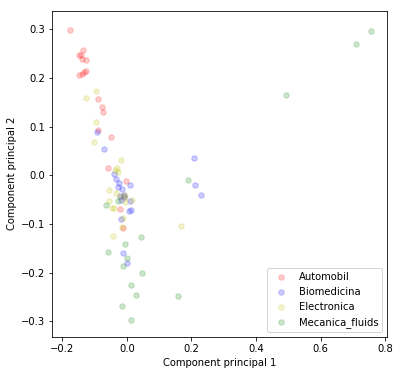

In [242]:
##Plotting 2D

fig2 = plt.figure(figsize = (6,6))
ax3 = fig2.add_subplot(1,1,1) 
ax3.set_xlabel('Component principal 1', fontsize = 10)
ax3.set_ylabel('Component principal 2', fontsize = 10)
#ax3.set_title('PCA 2D - Totes les dades - Tf idf', fontsize = 20)

targets = y.unique()
colors = ['r', 'b','y','g','k']

for target, color in zip(targets,colors):
    indicesToKeep = principalDf5['labels'] == target
    ax3.scatter(principalDf5.loc[indicesToKeep, 'principal component 1']
               , principalDf5.loc[indicesToKeep, 'principal component 2'], c = color, s = 30,alpha = 0.2)

ax3.legend(targets)

### PCA 2D conjunt de train (tf-idf)

In [243]:
input_PCA_full_cv1 = X_train_dtm3.toarray()
pca6 = PCA(n_components=2)
principalComponents = pca6.fit_transform(input_PCA_full_cv1)
principalDf6 = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf6['labels'] = list(y_train)
principalDf6.head(5)

,principal component 1,principal component 2,labels
0,-0.097255,0.287609,Automobil
1,-0.002699,-0.181357,Mecanica_fluids
2,-0.107681,0.112081,Electronica
3,-0.109071,0.101515,Biomedicina
4,0.002822,-0.152466,Biomedicina


In [244]:
explained_variance = pca6.explained_variance_ratio_
print('El component principal 1 conté un ratio de variança = '+str(explained_variance[0])+' mentre que el component principal 2 conté un ratio de variança de '+str(explained_variance[1]))


El component principal 1 conté un ratio de variança = 0.029565125067284946 mentre que el component principal 2 conté un ratio de variança de 0.02590609327226379


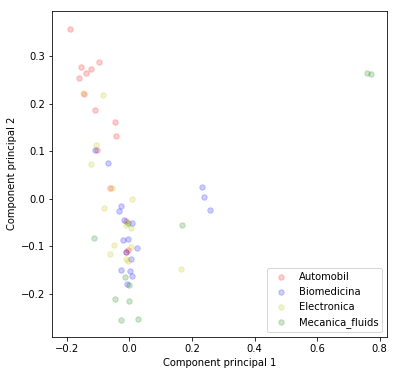

In [245]:
##Plotting 2D

fig2 = plt.figure(figsize = (6,6))
ax3 = fig2.add_subplot(1,1,1) 
ax3.set_xlabel('Component principal 1', fontsize = 10)
ax3.set_ylabel('Component principal 2', fontsize = 10)
#ax3.set_title('PCA 2D - Conjunt de train - Tf idf', fontsize = 20)

targets = y.unique()
colors = ['r', 'b','y','g','k']

for target, color in zip(targets,colors):
    indicesToKeep = principalDf6['labels'] == target
    ax3.scatter(principalDf6.loc[indicesToKeep, 'principal component 1']
               , principalDf6.loc[indicesToKeep, 'principal component 2'], c = color, s = 30,alpha = 0.2)

ax3.legend(targets)

## WORD2VEC

In [246]:
import multiprocessing
from gensim.models import Word2Vec

In [247]:
#PASSOS A REALITZAR
#1. Inicialitzo el word2vec amb els paràmetres necessaris i creo un vocabulari a partir de totes les paraules 
#que hi ha dins del meu conjunt de documents .txt. S'ha de fer un pre-processament inicial per eliminar:
#stopwords, fer stemming, elminar signes de puntuació i transformar a lower. 
#2. Entreno el word2vec amb tot el vocabulari
#3. Tokenitzo paraules conjunt train i test i les filtro per només quedar-me amb les que formen part del meu vocabulari
#4. Transformo paraules a vectors
#5. Calculo la mitjana de cada dimensió del vector per tal de tenir un mateix valor per inserir al model matemàtic 
#--> Resoulting vector would be your feature title representation
#6. Entreno al classificador amb el conjunt de train i evaluo en el conjunt de test

##### Creació del vocabulari pel word2vec

In [248]:
llista_text_documents_automobil = []
llista_text_documents_biomedicina = []
llista_text_documents_electronica = []
llista_text_documents_mecanica_fluids = []

for file in glob.glob('../00Data/dataset_txt/Biomedicina/*'):
    with open(file,'r') as txt:
        llista_text_documents_biomedicina.append(txt.read())

for file in glob.glob('../00Data/dataset_txt/Electronica/*'):
    with open(file,'r') as txt:
        llista_text_documents_electronica.append(txt.read())
        
for file in glob.glob('../00Data/dataset_txt/Mecanica_fluids/*'):
    with open(file,'r') as txt:
        llista_text_documents_mecanica_fluids.append(txt.read())
        
for file in glob.glob('../00Data/dataset_txt/Automobil/*'):
    with open(file,'r') as txt:
        llista_text_documents_automobil.append(txt.read())
        
#Ajunto tot el text de tots els documents en una unica llista per tal de processar-ho i tokenitzar-ho tot per
#obtenir el vocabulari necessàri pel word2vec
all_documents = llista_text_documents_automobil + llista_text_documents_biomedicina + llista_text_documents_electronica + llista_text_documents_mecanica_fluids

In [249]:
vocab_words = []

for tfg in all_documents:
    tfg = tfg.replace('\n',' ')
    for parag in tfg.split(' '):
        word_tokens = nltk.word_tokenize(parag)
        filtered_text = " ".join([w for w in word_tokens if not w in stopwords.words('spanish')])
        stemmed_text = " ".join(stemmer.stem(word) for word in nltk.word_tokenize(filtered_text))
        no_punctuaction_text = re.sub(r'[^\w\s]','',stemmed_text)
        no_digits_text = re.sub('\d', '', no_punctuaction_text)
        vocab_words.append(nltk.word_tokenize(no_digits_text))

    vocab_words

In [250]:
#Elimino els elements de la llista buits
vocab_words_clean = [x for x in vocab_words if x != []]
len(vocab_words_clean)

679043

In [251]:
#Inicialitzo el word2vec i li insereixo el vocabulari en el qual es basarà.
from gensim.models import Word2Vec
%time
w2v_model = Word2Vec(vocab_words_clean,
                     size=50, #Dimensió del vector
                     min_count=3, #Mínima d'aparaicions al vocabulari per ser considerat
                     window=2, #Paraules com a context
                     workers=4) #Número de fils d'execució         

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [252]:
len(w2v_model.wv.vocab) #Vocabulari del word2vec

12310

In [253]:
#S'han de filtrar les paraules dels títols dels TFG de tal manera que només es mantinguin aquelles que formen part
#del vocabulari del word2vec. Un cop fet això, ja disposaré d'un vector per a cada paraula.

#L'objectiu és  transformar els títols a FEATURES a partir dels vectors. Per a això, s'ha de calcular la mitjana
#de de cada dimensió de cada paraula que forma part d'un mateix títol. És a dir, si un títol te 5 paraules i la dimensió
#del word2vec és de 50. Hauré de calcular la mitjana dels valors de cada dimensió de les 5 paraules 50 cops.

#Un cop tingui els features dels títols, podré entrenar un classificador i validar.

In [254]:
#1. Filtrar les paraules dels títols de train i test en les conegudes pel word2vec

titulo_tokenizado_train = [] 
for element in X_train.tolist(): 
    titulo_tokenizado_train.append(nltk.word_tokenize(element))
    
filtered_title_train = []
for title in titulo_tokenizado_train:
    filtered_title_train.append([word for word in title if word in w2v_model.wv.vocab])
    
titulo_tokenizado_test = [] 
for element in X_test.tolist(): 
    titulo_tokenizado_test.append(nltk.word_tokenize(element))
    
filtered_title_test = []
for title in titulo_tokenizado_test:
    filtered_title_test.append([word for word in title if word in w2v_model.wv.vocab])                             

In [255]:
df_train = pd.DataFrame({'Title':X_train, 'Filtered_title_train' : filtered_title_train})
df_test = pd.DataFrame({'Title':X_test, 'Filtered_title_test' : filtered_title_test})

In [256]:
df_train.head(5)

,Title,Filtered_title_train
18,disen analisis vehicul electr liger movil urba...,"[disen, analisis, vehicul, electr, liger, movi..."
5,estudi dinam vuel girodin helicopter compuest,"[estudi, dinam, vuel, girodin, helicopter, com..."
20,disen implentacion amplif audi clas d control ...,"[disen, amplif, audi, clas, d, control, bas, m..."
11,disen sistem personaliz notif pacient riesg ca...,"[disen, sistem, personaliz, notif, pacient, ri..."
8,deteccion clasificacion diferent form eritroci...,"[deteccion, clasificacion, diferent, form, eri..."


In [257]:
w2v_model.vector_size

50

In [258]:
#Em permet obtenir un vector resultant que es la feature representation dels títols de train i test
titles_vectorized_train = []
for title in filtered_title_train:
    mean = []
    for word in title:
        mean.append(w2v_model.wv.get_vector(word))
     
    mean = np.array(mean).mean(axis=0)
    titles_vectorized_train.append(mean)
    
    
titles_vectorized_test = []
for title in filtered_title_test:
    mean = []
    for word in title:
        mean.append(w2v_model.wv.get_vector(word))
    mean = np.array(mean).mean(axis=0)
    titles_vectorized_test.append(mean)

In [259]:
print(len(titles_vectorized_train))
print(len(titles_vectorized_test))

59
20


In [260]:
df_train['titles_vectorized_train'] = titles_vectorized_train
df_test['titles_vectorized_test'] = titles_vectorized_test


X_train_dtm4 = df_train['titles_vectorized_train']
X_test_dtm4 = df_test['titles_vectorized_test']

df_train.head(5)

,Title,Filtered_title_train,titles_vectorized_train
18,disen analisis vehicul electr liger movil urba...,"[disen, analisis, vehicul, electr, liger, movi...","[-0.0010420661, -0.0031679752, -0.0017333939, ..."
5,estudi dinam vuel girodin helicopter compuest,"[estudi, dinam, vuel, girodin, helicopter, com...","[7.07036e-05, 0.0003088652, 0.00028170468, -0...."
20,disen implentacion amplif audi clas d control ...,"[disen, amplif, audi, clas, d, control, bas, m...","[-0.014793817, 0.014781517, 0.004235365, -0.01..."
11,disen sistem personaliz notif pacient riesg ca...,"[disen, sistem, personaliz, notif, pacient, ri...","[-0.0011348187, 0.00041147272, -0.0013615427, ..."
8,deteccion clasificacion diferent form eritroci...,"[deteccion, clasificacion, diferent, form, eri...","[-0.0014797689, 0.004655091, 0.0020485618, -0...."


### PCA 2D word2vec title embedding - train

In [261]:
input_PCA_full_w2v1 = X_train_dtm4.tolist()
pca7 = PCA(n_components=2)
principalComponents = pca7.fit_transform(input_PCA_full_w2v1)
principalDf7 = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf7['labels'] = list(y_train)
principalDf7.head(5)

,principal component 1,principal component 2,labels
0,-0.009688,-0.002715,Automobil
1,-0.001916,0.001463,Mecanica_fluids
2,0.125481,-0.007726,Electronica
3,0.012311,0.000338,Biomedicina
4,0.046943,0.002249,Biomedicina


In [262]:
explained_variance = pca7.explained_variance_ratio_
print('El componente principal 1 conté un ratio de variança = '+str(explained_variance[0])+' mentre que el componente principal 2 conté un ratio de variança de '+str(explained_variance[1]))


El componente principal 1 conté un ratio de variança = 0.6091688903115847 mentre que el componente principal 2 conté un ratio de variança de 0.04421620457291218


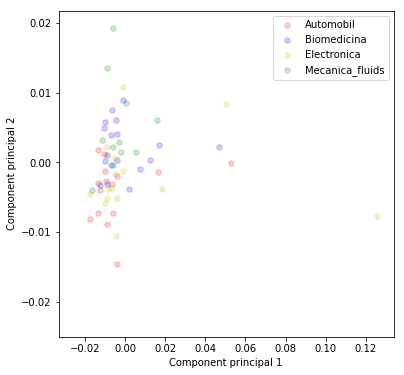

In [263]:
##Plotting 2D
fig2 = plt.figure(figsize = (6,6))
ax3 = fig2.add_subplot(1,1,1) 
ax3.set_xlabel('Component principal 1', fontsize = 10)
ax3.set_ylabel('Component principal 2', fontsize = 10)
#ax3.set_title('PCA 2D - Conjunt de train - W2V', fontsize = 20)

targets = y.unique()
colors = ['r', 'b','y','g','k']

for target, color in zip(targets,colors):
    indicesToKeep = principalDf7['labels'] == target
    ax3.scatter(principalDf7.loc[indicesToKeep, 'principal component 1']
               , principalDf7.loc[indicesToKeep, 'principal component 2'], c = color, s = 30,alpha = 0.2)

ax3.legend(targets)

### PCA 2D WORD2VEC - Tot el conjunt de dades

In [264]:
all_data_w2v = X_train_dtm4.tolist() + X_test_dtm4.tolist()

In [265]:
input_PCA_full_w2v1 = all_data_w2v
pca8 = PCA(n_components=2)
principalComponents = pca8.fit_transform(input_PCA_full_w2v1)
principalDf8 = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf8['labels'] = list(y_train)+list(y_test)
principalDf8.head(5)

,principal component 1,principal component 2,labels
0,-0.011674,-0.003385,Automobil
1,-0.003998,0.001567,Mecanica_fluids
2,0.124287,-0.007654,Electronica
3,0.010320,0.000695,Biomedicina
4,0.044987,0.002924,Biomedicina


In [266]:
explained_variance = pca8.explained_variance_ratio_
print('El component principal 1 conté un ratio de variança = '+str(explained_variance[0])+' mentre que el component principal 2 conté un ratio de variança de '+str(explained_variance[1]))

El component principal 1 conté un ratio de variança = 0.7561222573800795 mentre que el component principal 2 conté un ratio de variança de 0.02536213380156796


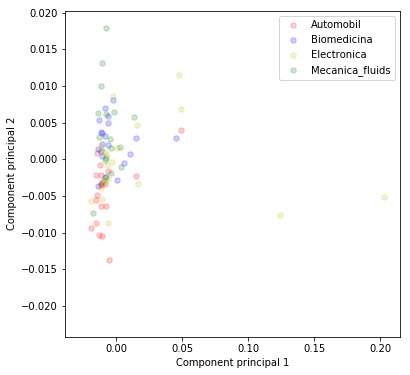

In [267]:
##Plotting 2D
fig2 = plt.figure(figsize = (6,6))
ax3 = fig2.add_subplot(1,1,1) 
ax3.set_xlabel('Component principal 1', fontsize = 10)
ax3.set_ylabel('Component principal 2', fontsize = 10)
#ax3.set_title('PCA 2D - Totes les dades - W2V', fontsize = 20)

targets = y.unique()
colors = ['r', 'b','y','g','k']

for target, color in zip(targets,colors):
    indicesToKeep = principalDf8['labels'] == target
    ax3.scatter(principalDf8.loc[indicesToKeep, 'principal component 1']
               , principalDf8.loc[indicesToKeep, 'principal component 2'], c = color, s = 30,alpha = 0.2)

ax3.legend(targets)

## MODELS

### Multinomial Naive Bayes

In [268]:
from sklearn.naive_bayes import MultinomialNB

In [269]:
#Faig GridSearchper a cada tipus de featuring en el model MNB.
#D'aquesta manera puc trobar els híper-paràmetres que millor s'ajusten al model 

param_grid = {'alpha': np.arange(0,1.1,0.1)}
mnb_prueba = MultinomialNB()

In [270]:
param_grid

{'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

In [271]:
grid_mnb_cv_countbased = GridSearchCV(estimator=mnb_prueba, param_grid=param_grid, cv = 3,n_jobs = -1)
grid_mnb_cv_binary = GridSearchCV(estimator=mnb_prueba, param_grid=param_grid, cv = 3,n_jobs = -1)
grid_mnb_tfidf = GridSearchCV(estimator=mnb_prueba, param_grid=param_grid, cv = 3,n_jobs = -1)


grid_result_1 = grid_mnb_cv_countbased.fit(X_train_dtm, y_train)
grid_result_2= grid_mnb_cv_binary.fit(X_train_dtm2, y_train)
grid_result_3 = grid_mnb_tfidf.fit(X_train_dtm3,y_train)




print("CV CountBased Best: %f using %s" % (grid_result_1.best_score_, grid_result_1.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("CV binary Best: %f using %s" % (grid_result_2.best_score_, grid_result_2.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("Tf-idf Best: %f using %s" % (grid_result_3.best_score_, grid_result_3.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV CountBased Best: 0.677966 using {'alpha': 0.6000000000000001}
CV binary Best: 0.677966 using {'alpha': 0.6000000000000001}
Tf-idf Best: 0.644068 using {'alpha': 0.2}


/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [303]:
#Segons GridSearch, la millor opció és el featuring en CV binary i una alpha de 0.6
#Un cop triat el millor tipus de configuració. 
#Inicialitzo un model amb aquestes característiques i avaluo sobre X_test

mnb = MultinomialNB(alpha = 0.6)
%time mnb.fit(X_train_dtm2,y_train)

CPU times: user 4.21 ms, sys: 9.42 ms, total: 13.6 ms
Wall time: 14 ms


MultinomialNB(alpha=0.6, class_prior=None, fit_prior=True)

In [304]:
y_pred_class = mnb.predict(X_test_dtm2)

In [305]:
metrics.accuracy_score(y_test,y_pred_class)

0.95

In [306]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[4, 0, 0, 0],
       [0, 3, 0, 0],
       [1, 0, 6, 0],
       [0, 0, 0, 6]])

### Support Vector Machine linear

In [276]:
#Faig GridSearch per a cada tipus de featuring en el model SVM.
#D'aquesta manera puc trobar els híper-paràmetres que millor s'ajusten al model 
param_grid2 = {'C': np.arange(1,1000,1)}
svm = SVC(kernel='linear')

In [277]:
grid_svm_cv_countbased = GridSearchCV(estimator=svm, param_grid=param_grid2, cv = 3,n_jobs = -1)
grid_svm_cv_binary = GridSearchCV(estimator=svm, param_grid=param_grid2, cv = 3,n_jobs = -1)
grid_svm_tfidf = GridSearchCV(estimator=svm, param_grid=param_grid2, cv = 3,n_jobs = -1)
grid_svm_w2v = GridSearchCV(estimator=svm, param_grid = param_grid2, cv=3 , n_jobs = -1)


grid_result_4 = grid_svm_cv_countbased.fit(X_train_dtm, y_train)
grid_result_5= grid_svm_cv_binary.fit(X_train_dtm2, y_train)
grid_result_6 = grid_svm_tfidf.fit(X_train_dtm3,y_train)
grid_result_7 = grid_svm_w2v.fit(X_train_dtm4.tolist(),y_train)




print("CV CountBased Best: %f using %s" % (grid_result_4.best_score_, grid_result_4.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("CV binary Best: %f using %s" % (grid_result_5.best_score_, grid_result_5.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("Tf-idf Best: %f using %s" % (grid_result_6.best_score_, grid_result_6.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("W2V Best: %f using %s" % (grid_result_7.best_score_, grid_result_7.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV CountBased Best: 0.711864 using {'C': 1}
CV binary Best: 0.711864 using {'C': 1}
Tf-idf Best: 0.711864 using {'C': 2}
W2V Best: 0.389831 using {'C': 997}


/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [278]:
#Segons GridSearch, la millor opció és el featuring en CV binary una C de 1
#Un cop triat el millor tipus de configuració. 
#Inicialitzo un model amb aquestes característiques i avaluo sobre X_test

svm_best = SVC(kernel='linear',C=1)
%time svm_best.fit(X_train_dtm,y_train)

CPU times: user 3.36 ms, sys: 1.74 ms, total: 5.1 ms
Wall time: 3.19 ms


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [279]:
y_pred_class2 = svm_best.predict(X_test_dtm)

In [280]:
metrics.accuracy_score(y_test,y_pred_class2)

0.9

In [281]:
metrics.confusion_matrix(y_test, y_pred_class2)

array([[4, 0, 0, 0],
       [0, 3, 0, 0],
       [0, 1, 6, 0],
       [0, 1, 0, 5]])

### Random Forest

In [282]:
from sklearn.ensemble import RandomForestClassifier

In [283]:
#Faig GridSearch per a cada tipus de featuring en el model Random forest.
#D'aquesta manera puc trobar els híper-paràmetres que millor s'ajusten al model 
param_grid3 = {'n_estimators': np.arange(1,1000,100),'max_depth' : np.arange(1,20,1)}
rf = RandomForestClassifier(random_state=4)

In [284]:
grid_rf_cv_countbased = GridSearchCV(estimator=rf, param_grid=param_grid3, cv = 3,n_jobs = -1)
grid_rf_cv_binary = GridSearchCV(estimator=rf, param_grid=param_grid3, cv = 3,n_jobs = -1)
grid_rf_tfidf = GridSearchCV(estimator=rf, param_grid=param_grid3, cv = 3,n_jobs = -1)
grid_rf_w2v = GridSearchCV(estimator=rf, param_grid=param_grid3, cv = 3,n_jobs = -1)

grid_result_8 = grid_rf_cv_countbased.fit(X_train_dtm, y_train)
grid_result_9= grid_rf_cv_binary.fit(X_train_dtm2, y_train)
grid_result_10 = grid_rf_tfidf.fit(X_train_dtm3,y_train)
grid_result_19 = grid_rf_tfidf.fit(X_train_dtm4.tolist(),y_train)

print("CV CountBased Best: %f using %s" % (grid_result_8.best_score_, grid_result_8.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("CV binary Best: %f using %s" % (grid_result_9.best_score_, grid_result_9.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("Tf-idf Best: %f using %s" % (grid_result_10.best_score_, grid_result_10.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("W2V Best: %f using %s" % (grid_result_19.best_score_, grid_result_19.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV CountBased Best: 0.711864 using {'max_depth': 17, 'n_estimators': 901}
CV binary Best: 0.711864 using {'max_depth': 17, 'n_estimators': 901}
Tf-idf Best: 0.423729 using {'max_depth': 3, 'n_estimators': 201}
W2V Best: 0.423729 using {'max_depth': 3, 'n_estimators': 201}


/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [344]:
#Com a resultat del GridSearch s'obté que la millor configuració pel model és:
#Featuring amb CV binari i amb els paràmetres max_depth = 17 i n_estimators=901

rf_best = RandomForestClassifier(max_depth=17,n_estimators=901,random_state=17)
%time rf_best.fit(X_train_dtm2,y_train)

CPU times: user 567 ms, sys: 38.4 ms, total: 605 ms
Wall time: 721 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=17, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=901,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [345]:
y_predicted3= rf_best.predict(X_test_dtm2)

In [346]:
metrics.accuracy_score(y_test,y_predicted3)

0.7

In [347]:
metrics.confusion_matrix(y_test,y_predicted3)

array([[4, 0, 0, 0],
       [0, 3, 0, 0],
       [0, 5, 2, 0],
       [0, 1, 0, 5]])

### K Nearest Neighbors

In [289]:
from sklearn.neighbors import KNeighborsClassifier

In [290]:
#Faig GridSearch per a cada tipus de featuring en el model Random forest.
#D'aquesta manera puc trobar els híper-paràmetres que millor s'ajusten al model 
param_grid4 = {'n_neighbors' : np.arange(1,15,1)}
knn = KNeighborsClassifier()

In [291]:
grid_knn_cv_countbased = GridSearchCV(estimator=knn, param_grid=param_grid4, cv = 3,n_jobs = -1)
grid_knn_cv_binary = GridSearchCV(estimator=knn, param_grid=param_grid4, cv = 3,n_jobs = -1)
grid_knn_tfidf = GridSearchCV(estimator=knn, param_grid=param_grid4, cv = 3,n_jobs = -1)
grid_knn_w2v = GridSearchCV(estimator=knn, param_grid=param_grid4, cv = 3,n_jobs = -1)


grid_result_11 = grid_knn_cv_countbased.fit(X_train_dtm, y_train)
grid_result_12= grid_knn_cv_binary.fit(X_train_dtm2, y_train)
grid_result_13 = grid_knn_tfidf.fit(X_train_dtm3,y_train)
grid_result_14 = grid_knn_tfidf.fit(X_train_dtm4.tolist(),y_train)


print("CV CountBased Best: %f using %s" % (grid_result_11.best_score_, grid_result_11.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("CV binary Best: %f using %s" % (grid_result_12.best_score_, grid_result_12.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("Tf-idf Best: %f using %s" % (grid_result_13.best_score_, grid_result_13.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("W2V Best: %f using %s" % (grid_result_14.best_score_, grid_result_14.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV CountBased Best: 0.457627 using {'n_neighbors': 4}
CV binary Best: 0.457627 using {'n_neighbors': 4}
Tf-idf Best: 0.508475 using {'n_neighbors': 3}
W2V Best: 0.508475 using {'n_neighbors': 3}


/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [313]:
#Com a resultat del GridSearch s'obté que la millor configuració pel model és:
#Featuring amb countvectorizer countbased i amb els paràmetres n_neighbors=4

knn_best = KNeighborsClassifier(n_neighbors = 4)
%time knn_best.fit(X_train_dtm,y_train)

CPU times: user 1.21 ms, sys: 791 µs, total: 2 ms
Wall time: 2.08 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [314]:
y_predicted4 = knn_best.predict(X_test_dtm)

In [315]:
metrics.accuracy_score(y_test,y_predicted4)

0.6

In [316]:
metrics.confusion_matrix(y_test,y_predicted4)

array([[4, 0, 0, 0],
       [2, 0, 1, 0],
       [5, 0, 2, 0],
       [0, 0, 0, 6]])

### Multinomial Logistic Regression 

In [296]:
from sklearn.linear_model import LogisticRegression

In [297]:
#Faig GridSearch per a cada tipus de featuring en el model Random forest.
#D'aquesta manera puc trobar els híper-paràmetres que millor s'ajusten al model 
param_grid5 = {'C' : np.arange(1,8000,5), 'solver':['lbfgs','newton-cg']}
#Especifico que serà un problema multinomial
mlr = LogisticRegression(multi_class='multinomial')

In [298]:
grid_mlr_cv_countbased = GridSearchCV(estimator=mlr, param_grid=param_grid5, cv = 3,n_jobs = -1)
grid_mlr_cv_binary = GridSearchCV(estimator=mlr, param_grid=param_grid5, cv = 3,n_jobs = -1)
grid_mlr_tfidf = GridSearchCV(estimator=mlr, param_grid=param_grid5, cv = 3,n_jobs = -1)
grid_mlr_w2v = GridSearchCV(estimator=mlr, param_grid=param_grid5, cv = 3,n_jobs = -1)


grid_result_15 = grid_mlr_cv_countbased.fit(X_train_dtm, y_train)
grid_result_16= grid_mlr_cv_binary.fit(X_train_dtm2, y_train)
grid_result_17 = grid_mlr_tfidf.fit(X_train_dtm3,y_train)
grid_result_18 = grid_mlr_tfidf.fit(X_train_dtm4.tolist(),y_train)



print("CV CountBased Best: %f using %s" % (grid_result_15.best_score_, grid_result_15.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("CV binary Best: %f using %s" % (grid_result_16.best_score_, grid_result_16.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

print("Tf-idf Best: %f using %s" % (grid_result_17.best_score_, grid_result_17.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')


print("W2V Best: %f using %s" % (grid_result_18.best_score_, grid_result_18.best_params_))
#print("Execution time: " + str((time.time() - start_time)) + ' ms'+'\n')

/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV CountBased Best: 0.711864 using {'C': 1, 'solver': 'lbfgs'}
CV binary Best: 0.711864 using {'C': 1, 'solver': 'lbfgs'}
Tf-idf Best: 0.593220 using {'C': 6686, 'solver': 'lbfgs'}
W2V Best: 0.593220 using {'C': 6686, 'solver': 'lbfgs'}


/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/rogerlopezsantalo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [317]:
#Com a resultat del GridSearch s'obté que la millor configuració pel model és:
#Featuring amb cv binary i amb els paràmetres C = 1 i solver lbfgs

mlr_best = LogisticRegression(C=1,solver='lbfgs',multi_class='multinomial')
%time mlr_best.fit(X_train_dtm2,y_train)

CPU times: user 13.3 ms, sys: 812 µs, total: 14.1 ms
Wall time: 16.2 ms


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [318]:
y_predicted5 = mlr_best.predict(X_test_dtm2)

In [319]:
metrics.accuracy_score(y_test,y_predicted5)

0.9

In [320]:
metrics.confusion_matrix(y_test,y_predicted5)

array([[4, 0, 0, 0],
       [0, 3, 0, 0],
       [0, 2, 5, 0],
       [0, 0, 0, 6]])

### Entrenar el millor algorisme amb totes les dades i descarregar-lo en un arxiu .pkl

#### MNB + cv binary

In [333]:
#Entreno amb totes les dades el millor algorisme
mnb_definitiu = MultinomialNB(alpha=0.6)
%time mnb_definitiu.fit(X_transf_dtm2,y)

CPU times: user 3.97 ms, sys: 12.4 ms, total: 16.3 ms
Wall time: 27.4 ms


MultinomialNB(alpha=0.6, class_prior=None, fit_prior=True)

In [334]:
#Descarrego el model
pkl_filename = "model_classificacio_mnb.pkl"
with open('../03Models/'+pkl_filename, 'wb') as file:
    pickle.dump(mnb_definitiu, file)

In [335]:
#Descarrego l'extractor de features en un arxiu
#Per descarregar-ho he de descarregar cv_max
feature_pkl_filename = "cv_binary.pkl"
with open('../03Models/'+feature_pkl_filename, 'wb') as file:
    pickle.dump(cv_max, file)


#### Prova model classificació en múltiples categories (CountVectorizer binary + mlr)

In [336]:
with open('../03Models/classificacio/cv_binary.pkl', 'rb') as file:
    pickle_feature = pickle.load(file)

In [337]:
#MNB + CV BINARY
with open('../03Models/classificacio/model_classificacio_mnb.pkl', 'rb') as file:
    pickle_model = pickle.load(file)

In [339]:
def prediccion(titulo):
    stemmer = SnowballStemmer('spanish')
    word_tokens = nltk.word_tokenize(titulo)
    text_without_stopwords= " ".join([w for w in word_tokens if not w in stopwords.words('spanish')])
    stemmed_text = " ".join(stemmer.stem(word) for word in nltk.word_tokenize(text_without_stopwords))
    no_punctuaction_text = re.sub(r'[^\w\s]','',stemmed_text)
    no_digits_text = re.sub('\d', '', no_punctuaction_text)
    
    X = pickle_feature.transform(pd.Series(no_digits_text))
    return(pickle_model.predict(X))

In [340]:
prediccion('La intubación en pacientes')

array(['Biomedicina'], dtype='<U15')

In [341]:
prediccion('Sistema de regulación de temperatura de una fabrica')

array(['Electronica'], dtype='<U15')

In [342]:
prediccion('Máquinas frigoríficas, refrigeración por compresión de vapor')

array(['Mecanica_fluids'], dtype='<U15')

In [343]:
prediccion('Curvas características de una bomba hidráulica centrífuga')

array(['Mecanica_fluids'], dtype='<U15')